In [1]:
!pip install tensorflow==2.9.1

Dataset Description:
Skin Cancer: Malignant vs Benign
This dataset contains a balanced dataset of images of benign skin moles and malignant skin moles.
Content:
The data consists of two folders with each 1800 pictures (224x244) of the two types of moles.

All the rights of the Data are bound to the ISIC-Archive rights (https://www.isic-archive.com/#!/topWithHeader/wideContentTop/main). 



In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
# >>> FIXED IMPORT (was split across two lines)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print('modules loaded')

modules loaded


In [4]:
# -----------------------------
# DATA HELPERS (tweaked for robustness)
# -----------------------------
def define_paths(data_dir):
    """
    Collect image filepaths + labels from a directory that contains class subfolders.
    Only iterates subdirectories (class names).
    """
    filepaths, labels = [], []
    for fold in os.listdir(data_dir):
        foldpath = os.path.join(data_dir, fold)
        if not os.path.isdir(foldpath):
            continue  # skip files at root
        for file in os.listdir(foldpath):
            fpath = os.path.join(foldpath, file)
            if os.path.isfile(fpath):
                filepaths.append(fpath)
                labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

def split_data(train_dir, test_dir):
    # train & valid
    files, classes = define_paths(train_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(
        df, train_size=0.8, shuffle=True, random_state=123, stratify=strat
    )
    # test
    files, classes = define_paths(test_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

def split_from_single_root(root_dir):
    """
    If skin_cancer/ has only class subfolders (no train/test),
    do an 80/10/10 split without moving files.
    """
    files, classes = define_paths(root_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, temp_df = train_test_split(
        df, train_size=0.8, shuffle=True, random_state=123, stratify=strat
    )
    valid_df, test_df = train_test_split(
        temp_df, train_size=0.5, shuffle=True, random_state=123, stratify=temp_df['labels']
    )
    return train_df, valid_df, test_df

def load_skin_cancer_from_path(base_dir):
    """
    Load dataset from a fixed local path.
      - If {base_dir}/train and {base_dir}/test exist, use them.
      - Else assume {base_dir}/ has class subfolders and auto-split 80/10/10.
    """
    base_dir = os.path.normpath(base_dir)
    train_dir = os.path.join(base_dir, "train")
    test_dir  = os.path.join(base_dir, "test")
    if os.path.isdir(train_dir) and os.path.isdir(test_dir):
        print(f"Detected split dirs:\n  train={train_dir}\n  test={test_dir}")
        return split_data(train_dir, test_dir)
    else:
        print(f"Detected single-root dataset at: {base_dir} — splitting 80/10/10...")
        return split_from_single_root(base_dir)


In [6]:
# -----------------------------
# GENERATORS (unchanged logic)
# -----------------------------
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1)
                                  if ts_length % n == 0 and ts_length / n <= 80])) if ts_length else batch_size
    test_steps = ts_length // test_batch_size if ts_length else 0

    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    train_gen = tr_gen.flow_from_dataframe(
        train_df, x_col='filepaths', y_col='labels', target_size=img_size,
        class_mode='categorical', color_mode=color, shuffle=True, batch_size=batch_size
    )
    valid_gen = ts_gen.flow_from_dataframe(
        valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
        class_mode='categorical', color_mode=color, shuffle=True, batch_size=batch_size
    )
    test_gen = ts_gen.flow_from_dataframe(
        test_df, x_col='filepaths', y_col='labels', target_size=img_size,
        class_mode='categorical', color_mode=color, shuffle=False, batch_size=test_batch_size
    )

    return train_gen, valid_gen, test_gen

def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    length = len(labels)
    sample = min(length, 25)
    plt.figure(figsize=(20, 20))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255.0
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

In [7]:
# -----------------------------
# YOUR CALLBACK CLASS (unchanged)
# -----------------------------
class MyCallback(keras.callbacks.Callback):
    # ... keep your existing implementation exactly as you had it ...
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()
    def on_train_begin(self, logs=None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()
    # ... keep the rest of methods unchanged ...

Detected split dirs:
  train=C:\Users\awwal\Desktop\MLEA_experiments\skin_cancer\train
  test=C:\Users\awwal\Desktop\MLEA_experiments\skin_cancer\test
Found 2109 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
Found 660 validated image filenames belonging to 2 classes.


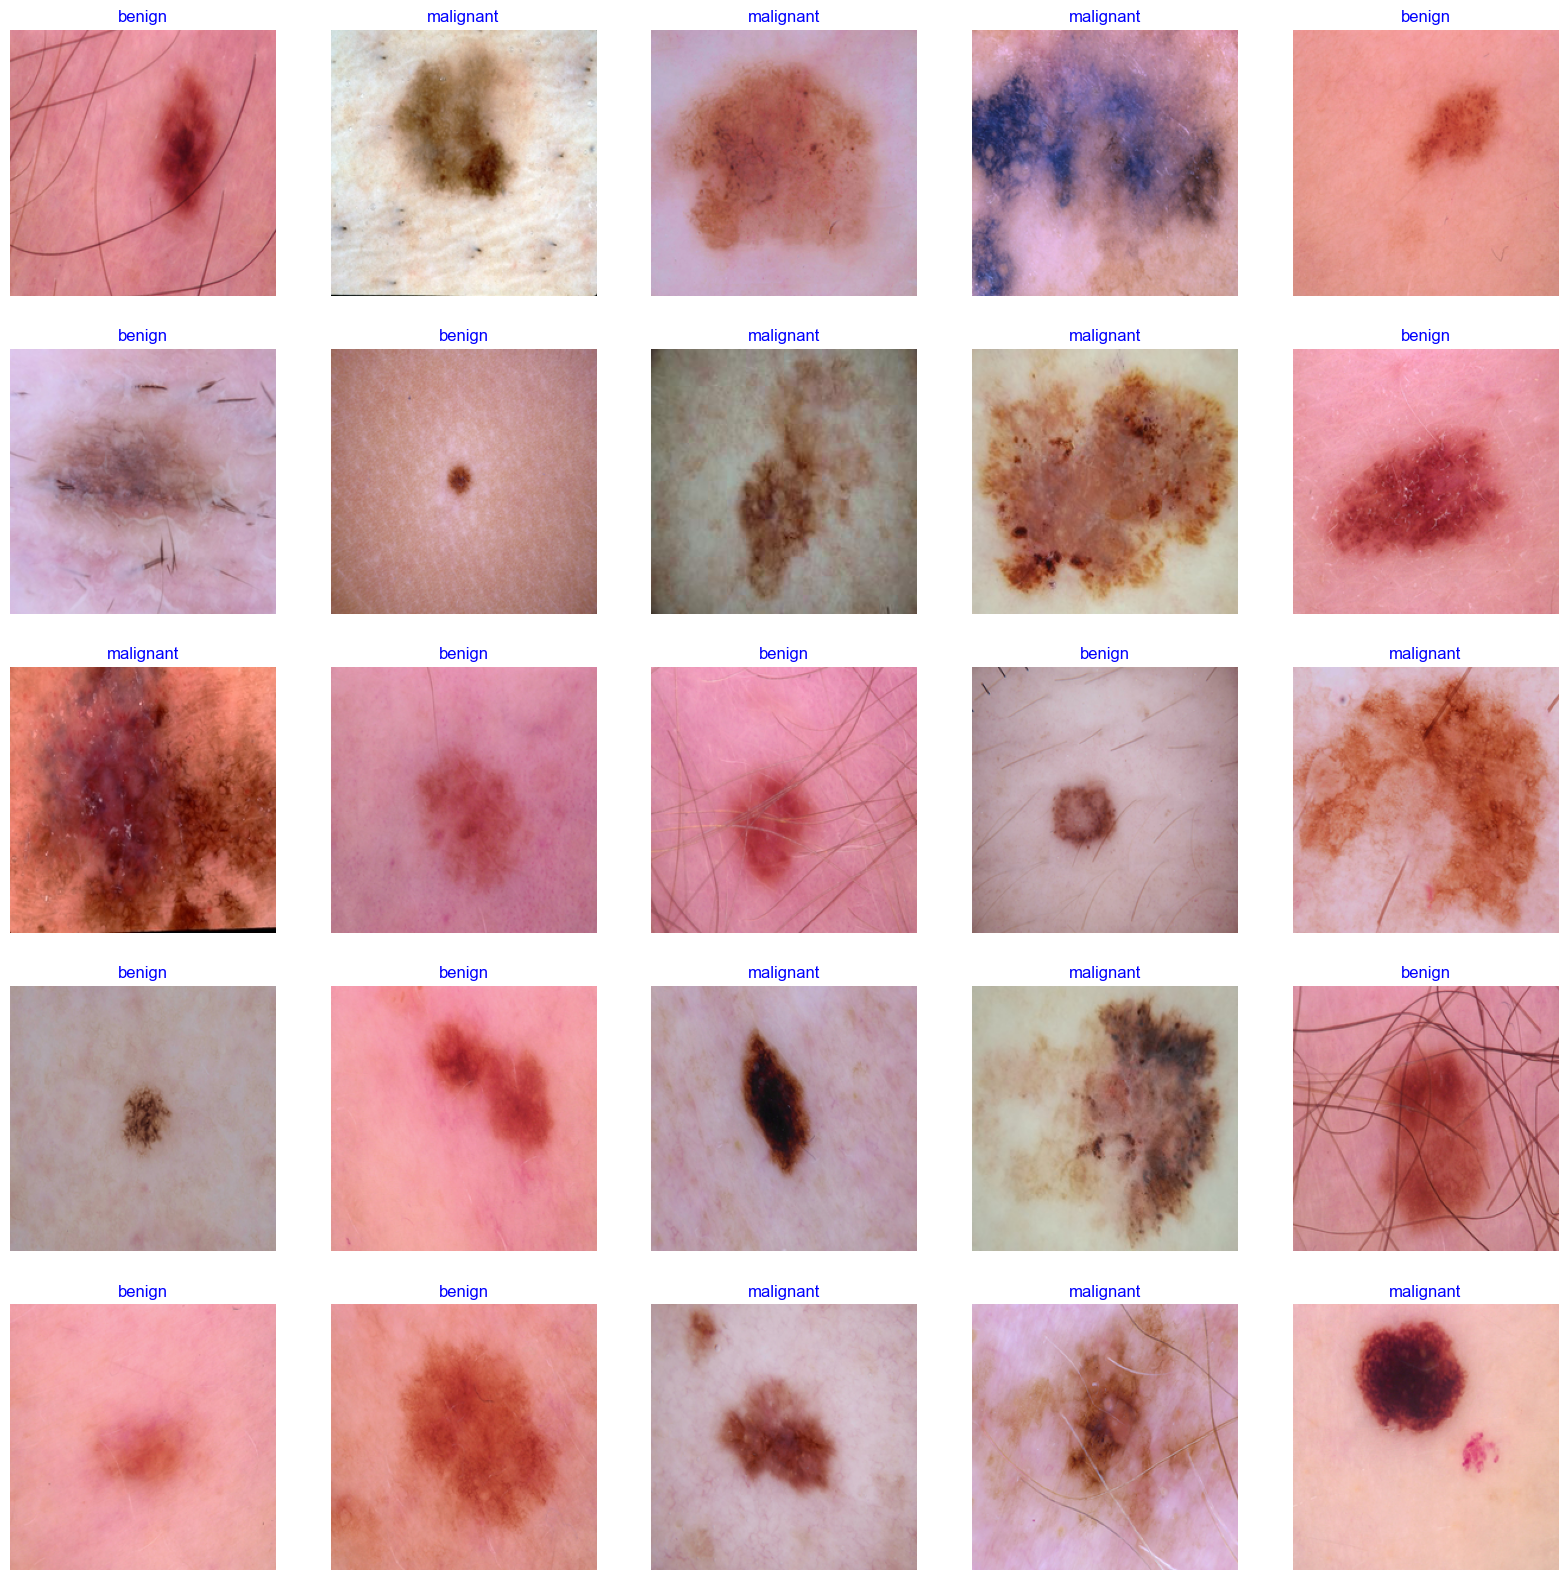

In [8]:
# ------------------------------------
# >>> SET YOUR LOCAL WINDOWS DATA PATH
# ------------------------------------
DATA_ROOT = r"C:\Users\awwal\Desktop\MLEA_experiments\skin_cancer"

try:
    # Load from your local path (handles either train/test split or single-root)
    train_df, valid_df, test_df = load_skin_cancer_from_path(DATA_ROOT)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except Exception as e:
    print('Invalid Input:', e)
    raise

show_images(train_gen)


In [9]:
# -----------------------------
# Generic Model Creation
# -----------------------------
# (Make sure this header line is a comment; an un-commented text line would break Python)

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # to define number of classes in dense layer

# Pretrained base: EfficientNetB3
base_model = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'
)

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

batch_size = 40
epochs = 40
patience = 1
stop_patience = 3
threshold = 0.9
factor = 0.5
batches = int(np.ceil(len(train_gen.labels) / batch_size))

callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience,
                        threshold=threshold, factor=factor, batches=batches, epochs=epochs, ask_epoch=5)]

history = model.fit(x=train_gen, epochs=epochs, verbose=0, callbacks=callbacks,
                    validation_data=valid_gen, validation_steps=None, shuffle=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11,183,665
Trainable params: 11,093,290
Non-trainable params: 90,375
_______________________________________

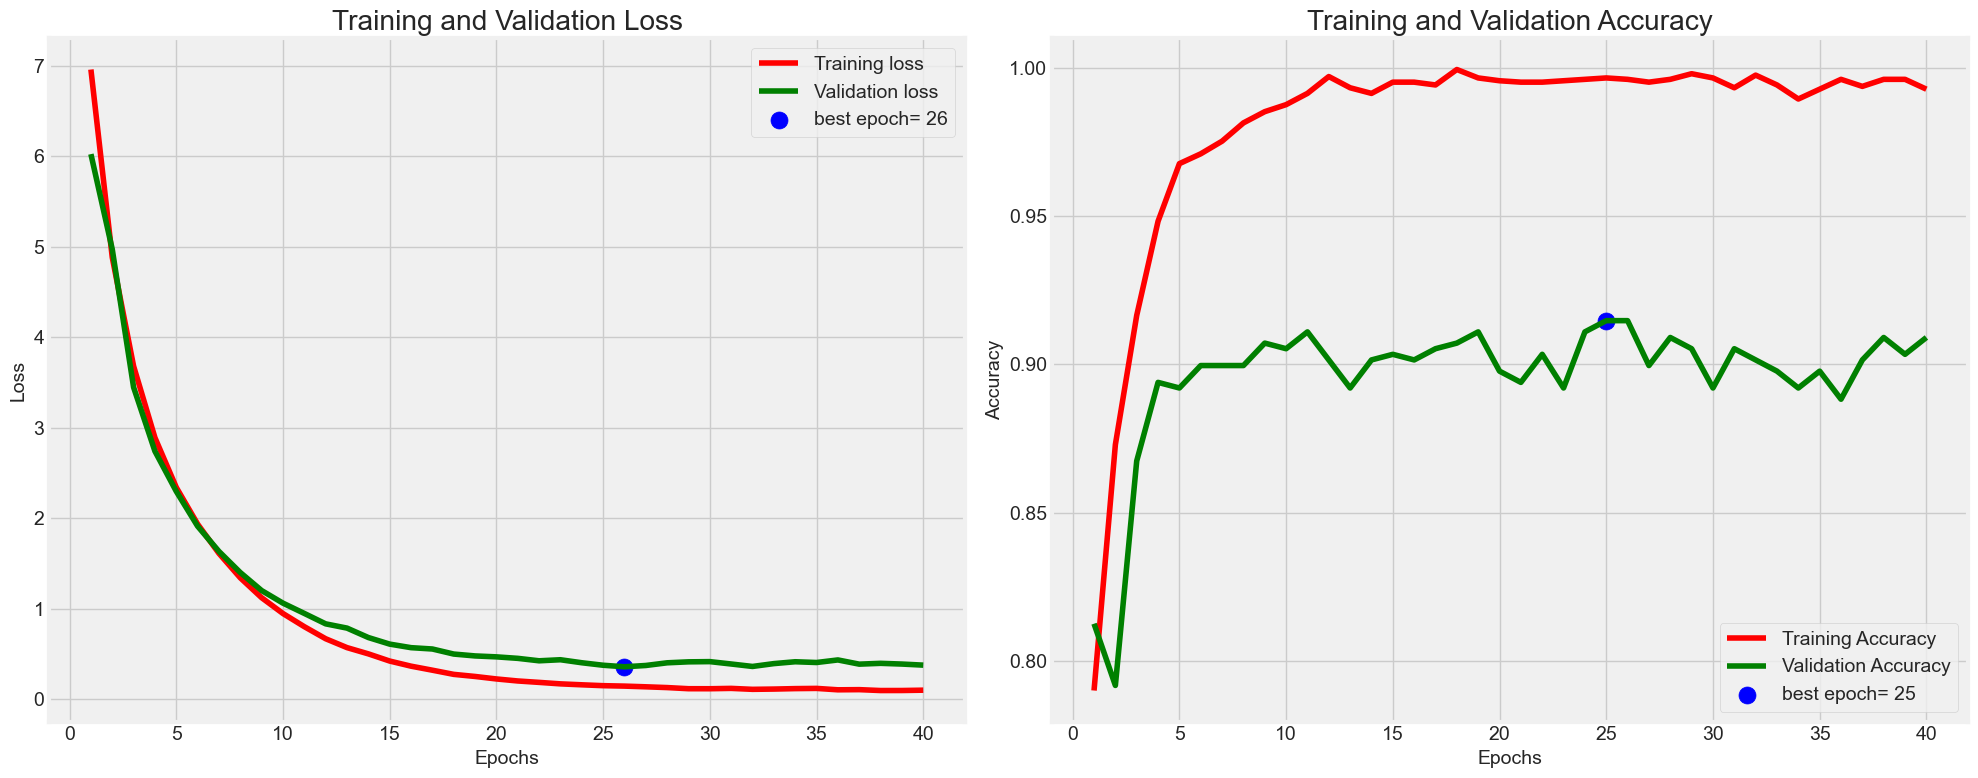

In [10]:

# -----------------------------
# Plot training
# -----------------------------
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()
    plt.tight_layout(); plt.show()

plot_training(history)

In [11]:
# -----------------------------
# Evaluate
# -----------------------------
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1)
                              if ts_length % n == 0 and ts_length / n <= 80])) if ts_length else 1
test_steps = ts_length // test_batch_size if test_batch_size else 0

train_score = model.evaluate(train_gen, steps=int(np.ceil(train_gen.n / train_gen.batch_size)), verbose=1)
valid_score = model.evaluate(valid_gen, steps=int(np.ceil(valid_gen.n / valid_gen.batch_size)), verbose=1)
test_score  = model.evaluate(test_gen,  steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0]); print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0]); print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0]); print("Test Accuracy: ", test_score[1])

10/10 [==============================] - 33s 3s/step - loss: 0.4254 - accuracy: 0.8848
Train Loss:  0.07571111619472504
Train Accuracy:  0.9995258450508118
--------------------
Validation Loss:  0.3779658377170563
Validation Accuracy:  0.9090909361839294
--------------------
Test Loss:  0.4254094958305359
Test Accuracy:  0.8848484754562378


10/10 [==============================] - 34s 3s/step
Confusion Matrix, Without Normalization
[[317  43]
 [ 33 267]]
              precision    recall  f1-score   support

      benign       0.91      0.88      0.89       360
   malignant       0.86      0.89      0.88       300

    accuracy                           0.88       660
   macro avg       0.88      0.89      0.88       660
weighted avg       0.89      0.88      0.88       660



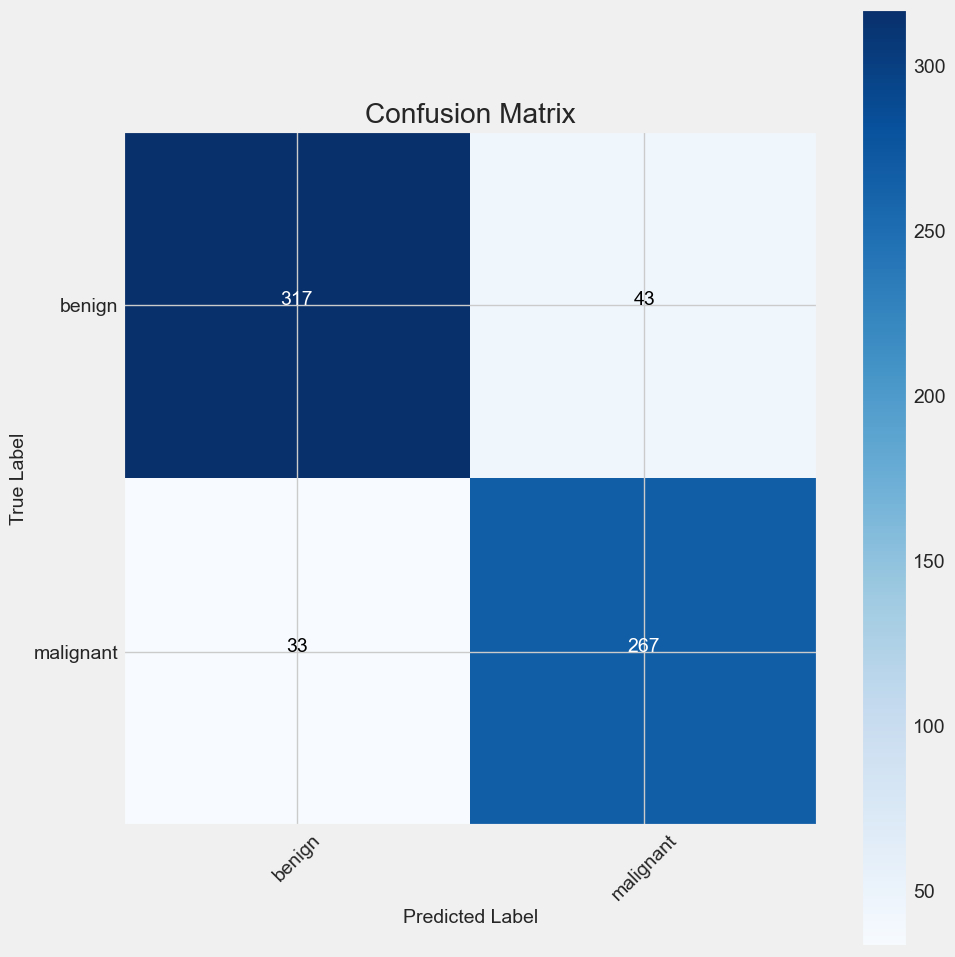

In [12]:
# -----------------------------
# Predictions & reports
# -----------------------------
# >>> replace deprecated predict_generator
preds = model.predict(test_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title); plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45); plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout(); plt.ylabel('True Label'); plt.xlabel('Predicted Label')

plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix')
print(classification_report(test_gen.classes, y_pred, target_names=classes))

In [13]:
# -----------------------------
# Save model & label map
# -----------------------------
model_name = model.input_names[0][:-6]
subject = 'Skin Cancer'
acc = test_score[1] * 100
save_path = ''  # current working directory

save_id = f'{model_name}-{subject}-{acc:.2f}.h5'
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

weight_save_id = f'{model_name}-{subject}-weights.h5'
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

class_dict = train_gen.class_indices
img_size_tuple = train_gen.image_shape
height = [img_size_tuple[0]] * len(class_dict)
width  = [img_size_tuple[1]] * len(class_dict)

class_df = pd.DataFrame({
    'class_index': list(class_dict.values()),
    'class': list(class_dict.keys()),
    'height': height,
    'width': width,
})
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index=False)
print(f'class csv file was saved as {csv_save_loc}')


model was saved as efficientnetb3-Skin Cancer-88.48.h5
weights were saved as efficientnetb3-Skin Cancer-weights.h5
class csv file was saved as Skin Cancer-class_dict.csv
